<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/videos/Practica_5_3_Modelo_lognormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5.3: Modelo lognormal

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov e inferencia variacional) problemas de inferencia estadística. En particular, vamos a proponer modelos de probabilidad condicionada con una única variable predictora, ya sea continua o discreta.

Para ello nos montaremos sobre dos librerías (paquetes de funciones)
- [Bambi](https://bambinos.github.io/bambi/) (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- [ArviZ](https://python.arviz.org/en/stable/): para la visualización de los resultados de la inferencia y la evaluación de los modelos

## Librerías

En primer lugar, importamos o instalamos todas las librerías y funciones que utilizaremos a lo largo del Colab.

In [1]:
# importar librerias utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# librerias para abrir archivos
import io
from google.colab import files

# instalar bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.3 MB/s eta 0:00:00


## Ejemplo 1: Resistencia del hormigón como función de la relación agua-material cementicio

En este primer ejercicio, buscaremos responder la siguiente pregunta:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para eso, vamos a usar los datos de ensayos de probetas que tenemos disponibles y ajustar un modelo.

### El dataset

Contamos con 103 muestras de hormigón ensayadas a los 28 días. Las mismas se extrajeron de un dataset público disponible en el repositorio de la Universidad de California Irvine. Pueden acceder al dataset haciendo click [aquí](https://archive.ics.uci.edu/dataset/182/concrete+slump+test).

Este dataset elaborado por I-Cheng Yeh ha sido utilizado en numerosas investigaciones.

In [2]:
# Subir archivo al colab
uploaded = files.upload()

Saving concrete_tests.csv to concrete_tests.csv


In [4]:
# Creamos el dataframe
df_horm = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_horm

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82
...,...,...,...,...,...,...,...,...,...,...
98,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97
99,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23
100,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50
101,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17


Lo primero que vamos a hacer es, en forma rápida, crear una nueva columna de nombre `a_c` que represente la relación agua-material cementicio, que incluye el cemento, la escoria y las cenizas volantes.

También cambiaremos el nombre de la columna de resistencia para hacerlo más amigable.

In [5]:
# Construimos una variable a/c (relacion agua cemento)
df_horm['a_c'] = df_horm['Water']/(df_horm['Cement']+df_horm['Slag']+df_horm['Fly ash'])

# cambiamos el nombre de la resistencia a la compresion
df_horm.rename(columns={'Compressive Strength (28-day)(Mpa)': 'Resistencia_MPa'}, inplace=True)

df_horm

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Resistencia_MPa,a_c
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99,0.456522
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14,0.357853
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81,0.357285
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08,0.358000
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82,0.536585
...,...,...,...,...,...,...,...,...,...,...,...
98,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97,0.287050
99,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23,0.287146
100,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50,0.298943
101,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17,0.335698


Ya que queremos predecir la resistencia del hormigón para una determinada relación agua-cemento, veamos cómo interactuan estas dos variables entre sí en el dataset.

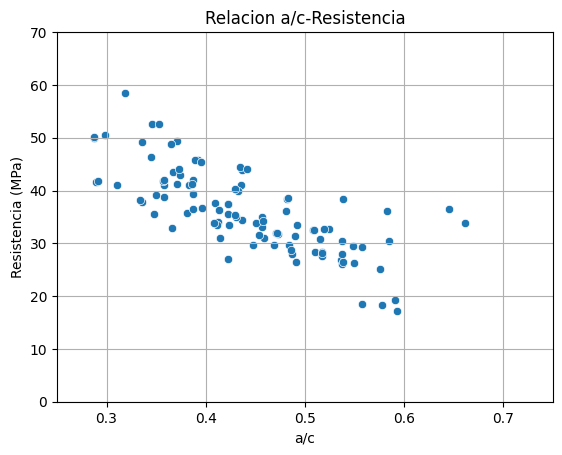

In [6]:
# graficamos la relacion a/c-Resistencia
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa')
plt.grid(True)
plt.xlabel('a/c')
plt.ylabel('Resistencia (MPa)')
plt.title('Relacion a/c-Resistencia')
plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Viendo el gráfico podrán notar dos cosas. Por un lado, no hay un sólo dato que tenga las relaciones agua-cemento que me interesan predecir. "No tengo los datos" para hacer un modelo de inferencia como veníamos trabajando hasta ahora (más allá de asumir que la `a/c` no importa y agrupar todo). Sin embargo, parece haber claramente una relación entre `a/c` y la resistencia ensayada de las probetas.

Por lo tanto, si pudiesemenos ajustar un modelo que determine cómo es esa relación entre `a/c` y la resistencia, podríamos luego usarlo para predecir datos nunca vistos como los pedidos al principio del problema.

### Modelo 4: Ley de Abrams (modelo lognormal)

Por último, vamos a ver cómo cargar un modelo lognormal. Como excusa, veremos la Ley de Abrams (no significa que el modelo de Abrams necesariamente sea lognormal)

Por empezar, recordemos que una variable $Y$ es lognormal si su logaritmo $Z=\log Y$ es normal. Entonces, si tratamos al modelo normal como uno de "valor medio más un error", como venimos haciendo:

$$Z = \log Y = \mu_{z} + error$$

$$error \sim Normal(0,\sigma)$$

Entonces el modelo para la variable $Y$ original me queda:

$$e^{Z} = Y = e^{\mu_{z}} \cdot e^{error}$$

¡Es un producto! En particular, un producto entre la mediana de $Y$ y un término de error que sigue una distribución lognormal de mediana igual a 1 y coeficiente de variación $\sigma$.

**En resumen**: Un modelo lognormal es un modelo donde se ajusta una curva para la mediana (en realidad, el valor medio del logaritmo), y el error se propaga como un error *relativo* definido por el parámetro $\sigma$ (el desvío estandar del logaritmo).

Aplicado a la Ley de Abrams, tenemos lo siguiente. Primero, la ecuación para la **mediana** es, según Abrams:

$$\bar y = \frac{c_{1}}{{c_{2}}^{a/c}}$$

El modelo que vamos a adoptar es de errores relativos (lognormal), por lo tanto:

$$y = \frac{c_{1}}{{c_{2}}^{a/c}}\cdot Error$$

donde $Error\sim LN(0,\sigma)$. Tomando el logaritmo, me queda:

$$z = \log c_{1} + \left(-\log c_{2}\right) \cdot a/c + error$$

donde $error \sim N(0,\sigma)$ es el error absoluto, normal, en el logaritmo. Es decir, ¡si tomo el logaritmo a los datos me queda un modelo normal típico como venimos trabajando!

**Resumen**: Por lo tanto, el modelo que estoy ajustando es una recta como venimos haciendo siempre, ¡pero para el logaritmo de las resistencias!

$$\log Y \sim N(\mu,\sigma)$$

$$\mu = A + B\cdot a/c$$

con prioris:

$$p(A) \sim Bambi$$
$$p(B) \sim Bambi$$
$$p(\sigma) \sim Bambi$$

**Nota**: $A=\log c_{1}$, $B = -\log c_{2}$

#### Construcción

La construcción en `Bambi` de este problema es directa: simplemente aclaro que lo que estoy ajustando es el logaritmo de la columna de Resistencias: `log(Resistencia_MPa)`. El valor medio del logaritmo sigue una recta, por la derivación que hicimos anteriormente.

ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: random_make_inplace
ERROR:pytensor.graph.rewriting.basic:node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/random/rewriting/basic.py", line 50, in random_make_inplace
    new_outputs = new_op.make_node(*node.inputs).outputs
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^

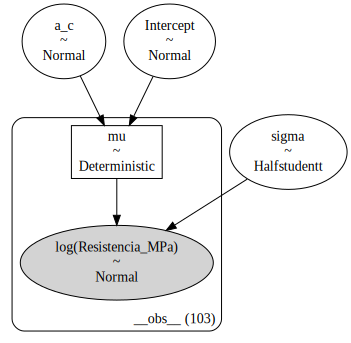

In [7]:
# creamos un modelo de ley de abrams (errores relativos)
model_4 = bmb.Model('log(Resistencia_MPa) ~ a_c', data=df_horm)
model_4.build()

# visualizacion
model_4.graph()

Una vez que llegué acá, es todo lo mismo de antes:

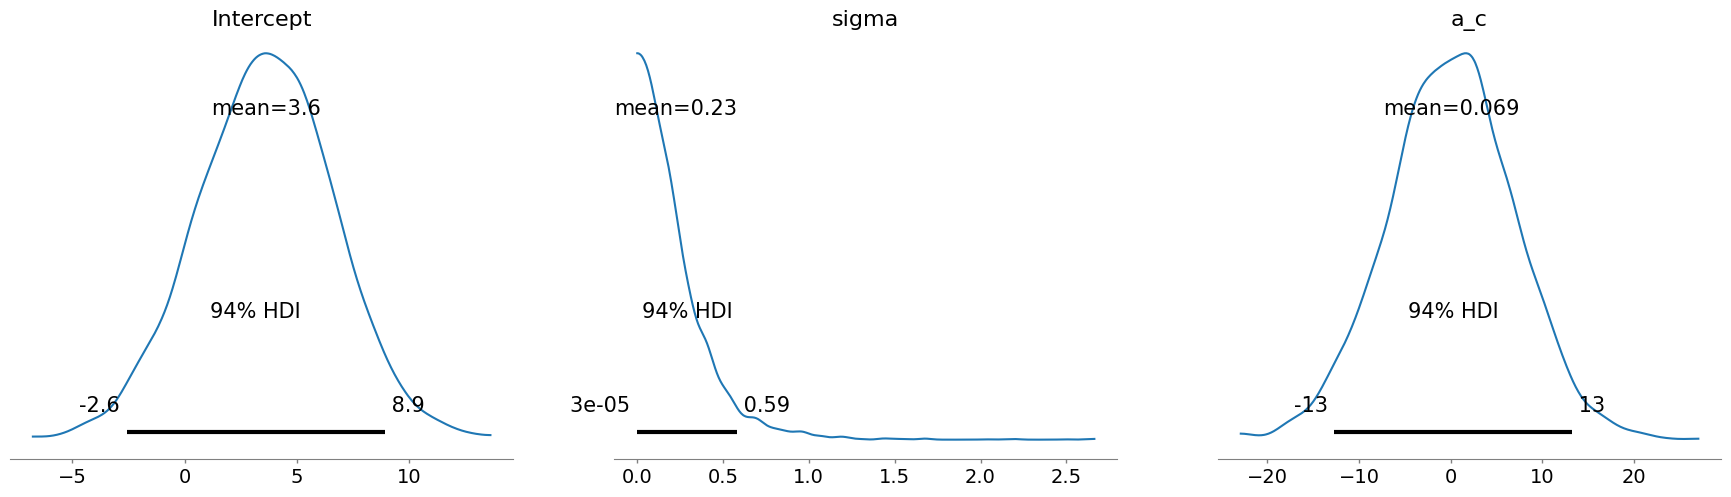

In [8]:
# ver distribuciones a priori
model_4.plot_priors()
plt.show()

Output()

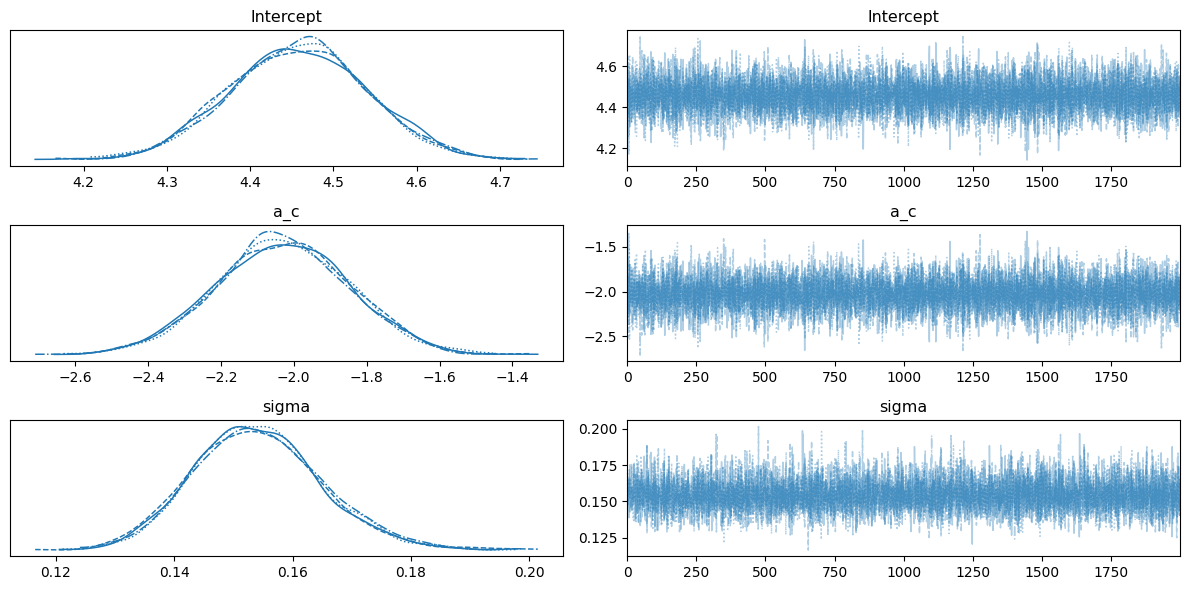

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.458,0.083,4.310,4.618,0.001,0.001,11916.0,5924.0,1.0
a_c,-2.030,0.184,-2.368,-1.683,0.002,0.002,11988.0,5986.0,1.0
sigma,0.154,0.011,0.134,0.175,0.000,0.000,11375.0,6075.0,1.0


In [9]:
# Realizar la inferencia
results_4 = model_4.fit(draws=2000, chains=4)

# visualizar cadenas
az.plot_trace(results_4)
plt.tight_layout()
plt.show()

# tabla resumen
az.summary(results_4)

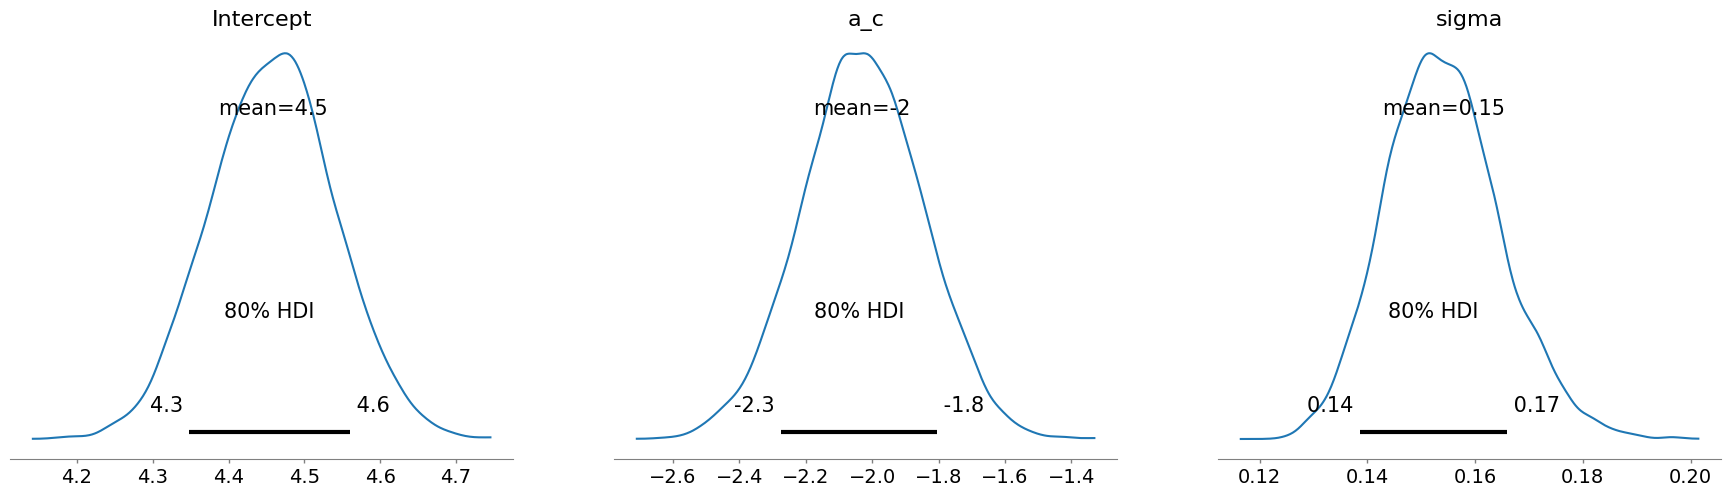

In [10]:
# ver distribucion posterior de los parametros del modelo
az.plot_posterior(results_4,hdi_prob=0.8)
plt.show()

El tema aparece a la hora de visualizar la ecuación. Como yo ajuste el logaritmo de la resistencia, el modelo está hecho para predecir logaritmos.

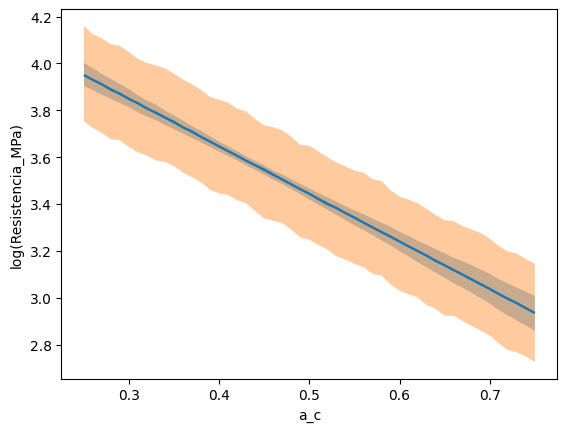

In [11]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,0.75,51)},pps=True,prob=0.8,ax=ax)
plt.show()

#### Transformación

Necesitamos, entonces, volver a la escala original en el gráfico de visualización del modelo. Para eso podemos usar la opción `transforms` dentro de la función `interpret.plot_predictions()`.

En este caso, lo que queremos hacer es exponenciar a los logaritmos de la resistencia predichos. Luego, manualmente le cambiamos el nombre del eje $y$ al gráfico.

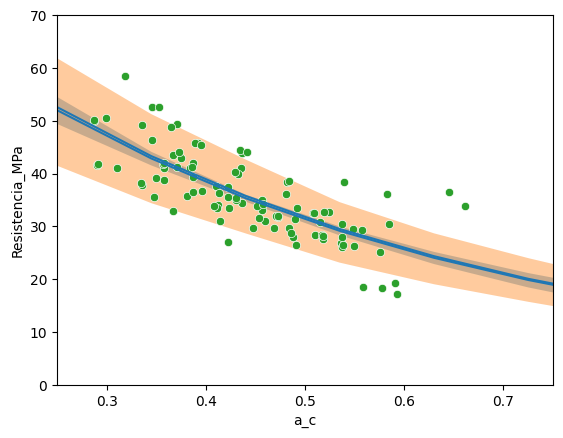

In [12]:
# visualizacion de la curva ajustada
fig,ax = bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=False,prob=0.8)
bmb.interpret.plot_predictions(model_4,results_4,conditional={'a_c':np.linspace(0.25,5,51)},transforms={'log(Resistencia_MPa)':lambda x: np.exp(x)},pps=True,prob=0.8,ax=ax)
plt.ylabel('Resistencia_MPa')

# agregado de los datos
sns.scatterplot(data=df_horm, x='a_c', y='Resistencia_MPa', ax=ax[0])

plt.xlim(0.25,0.75)
plt.ylim(0,70)
plt.show()

Noten como la sombra naranja (la dispersión de los resultados) disminuye a medida que disminuye el valor medio predicho. Esto es porque un modelo lognormal, es un modelo de errores relativos.

**Nota**: Que la dispersión se reduzca no parece justificarse por los datos. ¿Cómo podrían hacer para utilizar la ley de Abrams con un modelo de errores absolutos?

### Análisis de nuevos datos

Con lo que vimos hasta ahora ya sabemos construir y ajustar un modelo, y "ver qué da". Pero con eso no me alcanza para contestar la pregunta original:

**- ¿Cuál es la resistencia característica de un hormigón con relación agua-cemento (o material cementicio) de 0.4? ¿y si es 0.5?**

Para esto vamos a tener que generar simulaciones específicas para estos hormigones que nunca vi originalmente. En esta sección vamos a ver cómo simular datos que no vi.

#### Nuevo DataFrame

Así como para ajustar datos, a los datos vistos los ponemos dentro de un DataFrame, lo mismo haremos para los datos no vistos.

Yo quiero predecir la resistencia de hormigones con `a_c` de 0.4 y 0.5, así que me armo un DataFrame con estos nuevos datos de entrada (no tienen dato de salida porque nunca los ensayé).

In [13]:
# Analizar un hormigon con a/c = 0.4 y con a/c = 0.5
df_new = pd.DataFrame({'a_c':[0.4,0.5]})
df_new

,a_c
0,0.4
1,0.5


#### Predicción con el Modelo 4 (transformación)

¿Qué pasaba si quería hacer lo mismo pero con el modelo 4, lognormal? Nada, en sí es todo lo mismo.

In [14]:
# Generar simulaciones de las nuevas mezclas
results_4_new = model_4.predict(results_4,data=df_new,inplace=False,kind='response')

results_4_new

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

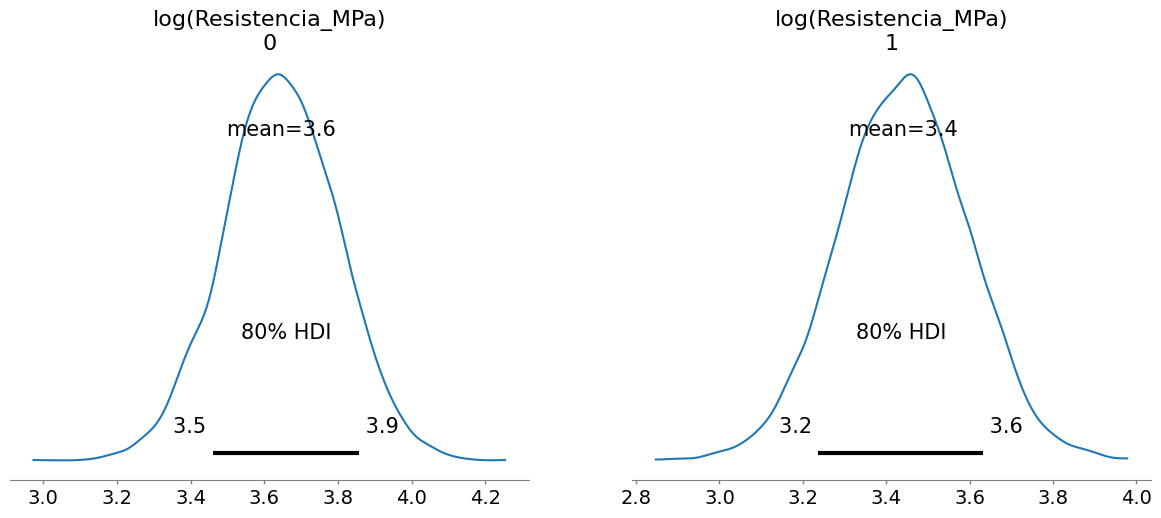

In [15]:
# grafico
az.plot_posterior(results_4_new,group='posterior_predictive',hdi_prob=0.8)
plt.show()

Claro, el tema es que predice logaritmos de las resistencias. Necesito, nuevamente transformar las simulaciones. Una opción recomendable es hacerlo con las funciones `.map()` y `.rename()` de ArviZ. Con la primera se ajustan, dentro del Inference Data, todas las cosas relacionadas a resistencia. La segunda simplemente cambia el nombre para dejar asentado que se hizo la transofrmación.

Esto me permite seguir usando las mismas funciones de antes en forma cómoda.

**Nota**: Verán que la transformación la guardo en nuevo Inference Data. Si bien no es necesario, sí es recomendable para no perder lo hecho originalmente.

In [16]:
# Transformo los datos
results_4_new_T = results_4_new.map(lambda x: np.exp(x),groups='observed_vars',inplace=False)

# Renombro
results_4_new_T.rename({'log(Resistencia_MPa)':'Resistencia_MPa'},inplace=True)

results_4_new_T

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Y, ahora sí, todo es igual que antes.

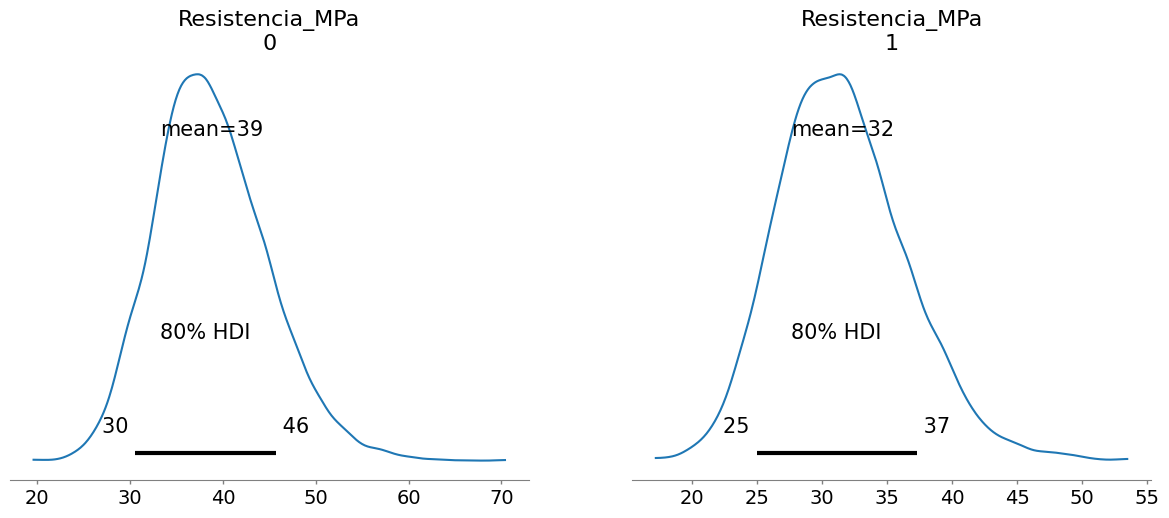

In [17]:
# grafico
az.plot_posterior(results_4_new_T,group='posterior_predictive',hdi_prob=0.8)
plt.show()

In [18]:
# ver el resultado de las simulaciones
Sims_4 = results_4_new_T.posterior_predictive['Resistencia_MPa'].values

# Resistencia Caracteristica
fc_4_0 = np.quantile(Sims_4[:,:,0],0.1)
fc_4_1 = np.quantile(Sims_4[:,:,1],0.1)

print('Resistencia caracteristica para a/c=0.4:',np.round(fc_4_0,2),'MPa')
print('Resistencia caracteristica para a/c=0.5:',np.round(fc_4_1,2),'MPa')

Resistencia caracteristica para a/c=0.4: 31.37 MPa
Resistencia caracteristica para a/c=0.5: 25.65 MPa
